In [1]:
%load_ext autoreload
%autoreload 2
from utils import load_inp_model, load_memory_inp_model, get_mask
import sys
import os
from argparse import Namespace
import json

from dataset.dataset import *
from dataset.utils import get_dataloader
from evaluation.utils import *

import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

plt.style.use("science")
sns.set_style("whitegrid")
sns.set_palette("Dark2")

plt.rcParams["text.latex.preamble"] = (
    "\\usepackage{lmodern} \\usepackage{times} \\usepackage{amssymb}"
)

/home/tsoump/memory-informed-meta-learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True

In [ ]:
# Load the models
save_dirs = {
    "NP": "../saves/INPs_sinusoids/np_0",
    "INP": "../saves/INPs_sinusoids/inp_abc2_0",
    "MemoryINP": "../saves/INPs_sinusoids/memory_inp_abc2_0",
}

models = list(save_dirs.keys())
model_dict = {}
config_dict = {}

for model_name, save_dir in save_dirs.items():
    if model_name == "MemoryINP":
        model_dict[model_name], config_dict[model_name] = load_memory_inp_model(
            save_dir, load_it="best"
        )
    else:
        model_dict[model_name], config_dict[model_name] = load_inp_model(
            save_dir, load_it="best"
        )
    model_dict[model_name].eval()

model_names = list(model_dict.keys())

In [4]:
# Setup the dataloaders
config = Namespace(
    min_num_context=0,
    max_num_context=100,
    num_targets=100,
    noise=0.2,
    batch_size=32,
    x_sampler="uniform",
    test_num_z_samples=32,
    dataset="set-trending-sinusoids",
    device="cuda:0",
)

dataset = SetKnowledgeTrendingSinusoids(
    root="../data/trending-sinusoids", split="test", knowledge_type="full"
)
data_loader = get_dataloader(dataset, config)

### **Important**: Due to lack of memory of VRAM (8gb available) I have to compute the summary_df table in two steps:
1. Compute the summary_df table for smaller context sets [0, 1, 3, 5, 10, 15]
2. Compute the summary_df table for larger context sets [30, 50, 100]

To do this: 

1. First uncomment the first num_context_ls and the corresponding .to_csv() lines and run the cell.
2. Then restart kernel and run the cell again with the second num_context_ls uncommented and the corresponding .to_csv() lines.
3. After that continue with the rest of the code that combines the two saved summary_df into a unified one.

In [5]:
# Evaluate the models on different knowledge types
eval_type_ls = ["raw", "informed", "a", "b", "c", "ab", "bc", "ac"]

# 1st run
num_context_ls = [0, 1, 3, 5, 10, 15]

# # 2nd run
# num_context_ls = [30, 50, 100]

if not os.path.exists("./artifacts"):
    os.makedirs("./artifacts")


summary_df, losses, outputs_dict = get_summary_df(
    model_dict, config_dict, data_loader, eval_type_ls, model_names, num_context_ls
)

summary_df["print_value"] = summary_df["mean"].apply(
    lambda x: f"{x:.1f}"
)
print_df = (
    summary_df.dropna(subset=["mean"])
    .pivot(
        columns="num_context", index=["model_name", "eval_type"], values=["print_value"]
    )
    .T.round(2)
)

# Convert losses to a format that can be serialized to JSON
losses_json = {}
for model_name, model_losses in losses.items():
    losses_json[model_name] = {}
    for eval_type, eval_losses in model_losses.items():
        losses_json[model_name][eval_type] = {}
        for num_context, context_losses in eval_losses.items():
            # Convert tensor lists to regular lists of floats
            losses_json[model_name][eval_type][num_context] = [
                loss.cpu().numpy().tolist() for loss in context_losses
            ]

# 1st run
print_df.to_csv("./artifacts/small_context_print_df.csv", index=False)
summary_df.to_csv("./artifacts/small_context_summary_df.csv", index=False)
loss_file = "./artifacts/small_context_losses.json"

# # 2nd run
# print_df.to_csv("./artifacts/large_context_print_df.csv", index=False)
# summary_df.to_csv("./artifacts/large_context_summary_df.csv", index=False)
# loss_file = "./artifacts/large_context_losses.json"

with open(loss_file, "w") as f:
    json.dump(losses_json, f)

print_df.droplevel(0, axis=0).dropna(axis=1, how="all")

In [ ]:
# Do some handling with pandas to combine the two print_df dataframes
# and make it have the same format as the small_context_df and large_context_df

small_context_print_df = pd.read_csv("./artifacts/small_context_print_df.csv")
large_context_print_df = pd.read_csv("./artifacts/large_context_print_df.csv")

large_context_values = large_context_print_df.values

# Get the rows from the large_context_df and append them to the small_context_df
small_context_print_df.loc[len(small_context_print_df)] = large_context_values[1]  # for context=30
small_context_print_df.loc[len(small_context_print_df)] = large_context_values[2]  # for context=50
small_context_print_df.loc[len(small_context_print_df)] = large_context_values[3]  # for context=100

# Set the columns and their names
model_names = ['INP'] * 8 + ['MemoryINP'] * 8 + ['NP']
eval_types = ['a', 'ab', 'ac', 'b', 'bc', 'c', 'informed', 'raw'] * 2 + ['raw']

columns = pd.MultiIndex.from_arrays([model_names, eval_types], names=['model_name', 'eval_type'])
small_context_print_df.columns = columns

# The first row contained column names, so remove it
small_context_print_df = small_context_print_df.iloc[1:]

# Set index to be the context sizes
small_context_print_df.index = pd.Index([0, 1, 3, 5, 10, 15, 30, 50, 100], name='num_context')
combined_print_df = small_context_print_df

combined_print_df = small_context_print_df

combined_print_df.to_csv("./artifacts/total_context_print_df.csv", index=False)
combined_print_df

In [ ]:
# Let's also do some handling with pandas to combine the two summary_df dataframes
small_context_summary_df = pd.read_csv("./artifacts/small_context_summary_df.csv")
large_context_summary_df = pd.read_csv("./artifacts/large_context_summary_df.csv")

combined_summary_df = pd.concat([small_context_summary_df, large_context_summary_df])

# Sort by model_name, eval_type, and num_context
combined_summary_df = combined_summary_df.sort_values(
    by=['model_name', 'eval_type', 'num_context']
).reset_index(drop=True)

combined_summary_df.to_csv("./artifacts/total_context_summary_df.csv", index=False)

combined_summary_df.head()

In [8]:
# Combine the two losses json files in a single dictionary
small_context_losses_path = "./artifacts/small_context_losses.json"
large_context_losses_path = "./artifacts/large_context_losses.json"
merged_losses_path = "./artifacts/merged_losses.json"

merged_losses = combine_dictionaries(small_context_losses_path, large_context_losses_path, merged_losses_path)

In [49]:
# This was used to generate the log likelihood boxplots for different knowledge types
# plot_df = (
#     combined_summary_df[
#         (combined_summary_df.model_name.isin(["MemoryINP", "INP", "NP"]))
#         & (combined_summary_df.eval_type.isin(["ab", "ac", "bc"]))
#     ]
#     .copy()
#     .reset_index(drop=True)
# )

# # Group by model_name and num_context, then calculate mean of "mean"
# mean_by_model_context = plot_df.groupby(['model_name', 'num_context'])['mean'].mean().reset_index()

# # Get rows with eval_type "raw" from the original dataframe
# raw_rows = combined_summary_df[
#     (combined_summary_df.model_name.isin(["MemoryINP", "INP", "NP"])) 
#     & (combined_summary_df.eval_type == "raw")
# ].copy()

# # Append raw rows to plot_df
# plot_df = pd.concat([mean_by_model_context, raw_rows], ignore_index=True)

# # Replace NaN values in the Knowledge column with "one"
# plot_df['eval_type'] = plot_df['eval_type'].fillna('two')

In [ ]:
plot_df = (
    combined_summary_df[
        (combined_summary_df.model_name.isin(["MemoryINP", "INP", "NP"]))
        & (combined_summary_df.eval_type.isin(["raw", "a", "b", "c"]))
    ]
    .copy()
    .reset_index(drop=True)
)
plot_df["mean"] = -plot_df["mean"]
plot_df = plot_df.rename(columns={"eval_type": "Knowledge", "model_name": "Model"})
plot_df["Knowledge"] = plot_df["Knowledge"].map(
    {
        "raw": r"$|\mathcal{K}| = 0$",
        "two": r"$|\mathcal{K}| = 2$",
    }
)

fig, ax = plt.subplots(figsize=(6, 4.5))
sns.lineplot(
    plot_df,
    x="num_context",
    y="mean",
    hue="Knowledge",
    style="Model",
    palette=["C2", "C4"],
    ax=ax,
    style_order=["MemoryINP", "INP", "NP"],
    markers=True,
)

ax.set_ylabel("Log likelihood")
ax.set_xlabel("Number of context points")

handles, labels = ax.get_legend_handles_labels()

labels[0] = ""
labels[3] = ""

plt.legend(labels=labels, handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('./artifacts/test_raw_two_k.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Delta-AUC
inp_model = "INP"
memory_inp_model = "MemoryINP"

eval_type_ls = ["a", "b", "c", "ab", "ac", "bc"]
num_context_ls = [0, 1, 3, 5, 10, 15, 30, 50, 100]

inp_auc_summary, _ = get_auc_summary(merged_losses, inp_model, eval_type_ls, num_context_ls)
memory_inp_auc_summary, _ = get_auc_summary(merged_losses, memory_inp_model, eval_type_ls, num_context_ls)

# Create dataframes for both models
inp_df = (pd.DataFrame(inp_auc_summary).T * 100).round(1)
inp_df.columns = ["mean", "se"]
inp_df["model"] = "INP"

memory_df = (pd.DataFrame(memory_inp_auc_summary).T * 100).round(1)
memory_df.columns = ["mean", "se"]
memory_df["model"] = "MemoryINP"

auc_df = pd.concat([inp_df, memory_df])
auc_df = auc_df.reset_index().rename(columns={"index": "knowledge_type"})

fig, ax = plt.subplots(figsize=(6, 3.5))
sns.barplot(
    data=auc_df,
    x="knowledge_type",
    y="mean",
    hue="model",
    ax=ax,
    palette=["C6", "C8"],
    alpha=0.85,
    width=0.7,
)

for i, model in enumerate(["INP", "MemoryINP"]):
    model_data = auc_df[auc_df.model == model]
    ax.errorbar(
        x=np.arange(len(model_data)) - 0.175 + i*0.35,
        y=model_data["mean"],
        yerr=model_data["se"],
        fmt="none",
        c="black",
        capsize=3,
    )

ax.set_ylabel("$\Delta$AUC [\%]")
ax.set_xlabel("Format of $\mathcal{K}$")
ax.set_xticklabels(
    ["$\\{%s\\}$" % ", ".join(list(k)) for k in eval_type_ls], rotation=0
)

plt.legend(title="Model", loc='upper right', facecolor="white", framealpha=0.8, frameon=True)
plt.tight_layout()
# plt.savefig('./artifacts/delta_auc_barplot.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Plot sample predictions for INP
for batch in data_loader:
    (x_context, y_context), (x_target, y_target), full_knowledge, extras = batch
    x_context = x_context.to(config.device)
    y_context = y_context.to(config.device)
    x_target = x_target.to(config.device)
    y_target = y_target.to(config.device)


num_context_ls = [0, 1, 3, 5, 10, 15, 30]
sample_idx = np.random.choice(list(range(x_target.shape[-2])), max(num_context_ls))
batch_idx = 0

fig, axs = plt.subplots(
    len(num_context_ls), 7, figsize=(15, 9), sharex=True, sharey=True
)

colors = {"raw": "grey", "a": "C1", "b": "C2", "c": "C3", "ab": "C4", "ac": "C5", "bc": "C6"}

titles = [
    "$\mathcal{K} = \emptyset$", 
    "$\mathcal{K} = \{a\}$", 
    "$\mathcal{K} = \{b\}$", 
    "$\mathcal{K} = \{c\}$", 
    "$\mathcal{K} = \{a,b\}$", 
    "$\mathcal{K} = \{a,c\}$", 
    "$\mathcal{K} = \{b,c\}$"
]
for ax, title in zip(axs[0], titles):
    ax.set_title(title)

y_labels = [
    "$N_c = 0$",
    "$N_c = 1$", 
    "$N_c = 3$",
    "$N_c = 5$",
    "$N_c = 10$",
    "$N_c = 15$",
    "$N_c = 30$"
]
for ax, label in zip(axs[:,0], y_labels):
    ax.set_ylabel(label)


for j, knowledge_type in enumerate(["raw", "a", "b", "c", "ab", "ac", "bc"]):
    if knowledge_type == "raw":
        knowledge = None
    else:
        mask = get_mask(knowledge_type)
        knowledge = full_knowledge * mask

    for i, num_context in enumerate(num_context_ls):
        x_context = x_target[:, sample_idx[:num_context], :]
        y_context = y_target[:, sample_idx[:num_context], :]

        with torch.no_grad():
            INP_outputs = model_dict["INP"](
                x_context, y_context, x_target, y_target=y_target, knowledge=knowledge
            )

        plot_predictions(
            axs[i][j],
            batch_idx,
            INP_outputs,
            x_context,
            y_context,
            x_target,
            extras,
            color=colors[knowledge_type],
            plot_true=True,
        )


plt.tight_layout()
plt.savefig('./artifacts/inp_predictions.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Plot sample predictions for MemoryINP
fig, axs = plt.subplots(
    len(num_context_ls), 7, figsize=(15, 9), sharex=True, sharey=True
)

colors = {"raw": "grey", "a": "C1", "b": "C2", "c": "C3", "ab": "C4", "ac": "C5", "bc": "C6"}

titles = [
    "$\mathcal{K} = \emptyset$", 
    "$\mathcal{K} = \{a\}$", 
    "$\mathcal{K} = \{b\}$", 
    "$\mathcal{K} = \{c\}$", 
    "$\mathcal{K} = \{a,b\}$", 
    "$\mathcal{K} = \{a,c\}$", 
    "$\mathcal{K} = \{b,c\}$"
]
for ax, title in zip(axs[0], titles):
    ax.set_title(title)

y_labels = [
    "$N_c = 0$",
    "$N_c = 1$", 
    "$N_c = 3$",
    "$N_c = 5$",
    "$N_c = 10$",
    "$N_c = 15$",
    "$N_c = 30$"
]
for ax, label in zip(axs[:,0], y_labels):
    ax.set_ylabel(label)


for j, knowledge_type in enumerate(["raw", "a", "b", "c", "ab", "ac", "bc"]):
    if knowledge_type == "raw":
        knowledge = None
    else:
        mask = get_mask(knowledge_type)
        knowledge = full_knowledge * mask

    for i, num_context in enumerate(num_context_ls):
        x_context = x_target[:, sample_idx[:num_context], :]
        y_context = y_target[:, sample_idx[:num_context], :]

        with torch.no_grad():
            MemoryINP_outputs = model_dict["MemoryINP"](
                x_context, y_context, x_target, y_target=y_target, knowledge=knowledge
            )

        plot_predictions(
            axs[i][j],
            batch_idx,
            MemoryINP_outputs,
            x_context,
            y_context,
            x_target,
            extras,
            color=colors[knowledge_type],
            plot_true=True,
        )


plt.tight_layout()
plt.savefig('./artifacts/memory_inp_predictions.pdf', bbox_inches='tight')
plt.show()

In [ ]:
knowledge_type_ls = ["raw", "informed", "a", "b", "c", "ab", "ac", "bc"]
num_context_ls = [0, 1, 3, 5, 10, 15]

uncertainties_inp = get_uncertainties(
    outputs_dict, num_context_ls, knowledge_type_ls, model_name="INP", n_batches=30
)

In [ ]:
knowledge_type_ls = ["raw", "informed", "a", "b", "c", "ab", "ac", "bc"]
num_context_ls = [0, 1, 3, 5, 10, 15]

uncertainties_memory_inp = get_uncertainties(
    outputs_dict, num_context_ls, knowledge_type_ls, model_name="MemoryINP", n_batches=30
)

In [ ]:
# Calculate percent differences between raw and other knowledge types
differences = {}
for num_context in num_context_ls:
    differences[num_context] = {}
    for knowledge_type in knowledge_type_ls[1:]:
        if knowledge_type == 'informed':
            continue
        differences[num_context][f'raw-{knowledge_type}'] = {}
        for batch_idx in uncertainties_memory_inp[num_context]['raw'].keys():
            differences[num_context][f'raw-{knowledge_type}'][batch_idx] = {}
            for uncert_type in uncertainties_memory_inp[num_context]['raw'][batch_idx].keys():
                raw_uncert = uncertainties_memory_inp[num_context]['raw'][batch_idx][uncert_type]
                other_uncert = uncertainties_memory_inp[num_context][knowledge_type][batch_idx][uncert_type]
                # Calculate percent difference: (raw - other)/raw * 100
                differences[num_context][f'raw-{knowledge_type}'][batch_idx][uncert_type] = ((raw_uncert - other_uncert) / raw_uncert) * 100

# Create boxplots for all knowledge type differences
data_lists = {}
for diff_type in differences[0].keys():
    data_lists[diff_type] = []
    for batch_idx in differences[0][diff_type].keys():
        data_lists[diff_type].append(differences[0][diff_type][batch_idx]['epistemic'].mean())

plt.figure(figsize=(10, 6))
boxplot_labels = [r'\{a\}', r'\{b\}', r'\{c\}', r'\{a,b\}', r'\{a,c\}', r'\{b,c\}']
bp = plt.boxplot([data_lists[k] for k in data_lists.keys()], labels=boxplot_labels, patch_artist=True)

for patch in bp['boxes']:
    patch.set_facecolor('olive')
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')

plt.setp(bp['whiskers'], color='black')
plt.setp(bp['caps'], color='black')
plt.setp(bp['medians'], color='black')

plt.title('Reduction in epistemic uncertainty')
plt.ylabel('Mean Uncertainty Percent Difference')
plt.xlabel(r'Format of $\mathcal{K}$')
plt.grid(axis='x')
plt.ylim(0, 8)
plt.tight_layout()
plt.savefig('./artifacts/uncertainty_reduction_boxplot.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Ablation study for MemoryINP: With and without memory

# Load the models
save_dirs = {
    "with_memory": "../saves/INPs_sinusoids/memory_inp_abc2",
    "without_memory": "../saves/INPs_sinusoids/no_memory",
}

models = list(save_dirs.keys())
model_dict = {}
config_dict = {}

for model_name, save_dir in save_dirs.items():
    model_dict[model_name], config_dict[model_name] = load_memory_inp_model(
        save_dir, load_it="best"
    )
    model_dict[model_name].eval()

model_names = list(model_dict.keys())

In [3]:
# Setup the dataloaders
config = Namespace(
    min_num_context=0,
    max_num_context=100,
    num_targets=100,
    noise=0.2,
    batch_size=32,
    x_sampler="uniform",
    test_num_z_samples=32,
    dataset="set-trending-sinusoids",
    device="cuda:0",
)

dataset = SetKnowledgeTrendingSinusoids(
    root="../data/trending-sinusoids", split="test", knowledge_type="full"
)
data_loader = get_dataloader(dataset, config)

In [ ]:
# Evaluate the models on different knowledge types
eval_type_ls = ["raw", "informed", "a", "b", "c", "ab", "bc", "ac"]

# # 1st run
# num_context_ls = [0, 1, 3, 5, 10, 15]

# 2nd run
num_context_ls = [30, 50, 100]

summary_df, losses, outputs_dict = get_summary_df(
    model_dict, config_dict, data_loader, eval_type_ls, model_names, num_context_ls
)

summary_df["print_value"] = summary_df["mean"].apply(
    lambda x: f"{x:.1f}"
)
print_df = (
    summary_df.dropna(subset=["mean"])
    .pivot(
        columns="num_context", index=["model_name", "eval_type"], values=["print_value"]
    )
    .T.round(2)
)

# Convert losses to a format that can be serialized to JSON
losses_json = {}
for model_name, model_losses in losses.items():
    losses_json[model_name] = {}
    for eval_type, eval_losses in model_losses.items():
        losses_json[model_name][eval_type] = {}
        for num_context, context_losses in eval_losses.items():
            # Convert tensor lists to regular lists of floats
            losses_json[model_name][eval_type][num_context] = [
                loss.cpu().numpy().tolist() for loss in context_losses
            ]

# # 1st run
# print_df.to_csv("./artifacts/with_without_memory_small_context_print_df.csv", index=False)
# summary_df.to_csv("./artifacts/with_without_memory_small_context_summary_df.csv", index=False)
# loss_file = "./artifacts/with_without_memory_small_context_losses.json"

# 2nd run
print_df.to_csv("./artifacts/with_without_memory_large_context_print_df.csv", index=False)
summary_df.to_csv("./artifacts/with_without_memory_large_context_summary_df.csv", index=False)
loss_file = "./artifacts/with_without_memory_large_context_losses.json"

with open(loss_file, "w") as f:
    json.dump(losses_json, f)

print_df.droplevel(0, axis=0).dropna(axis=1, how="all")

In [ ]:
# Do some handling with pandas to combine the two print_df dataframes

small_context_print_df = pd.read_csv("./artifacts/with_without_memory_small_context_print_df.csv")
large_context_print_df = pd.read_csv("./artifacts/with_without_memory_large_context_print_df.csv")

large_context_values = large_context_print_df.values

# Get the rows from the large_context_df and append them to the small_context_df
small_context_print_df.loc[len(small_context_print_df)] = large_context_values[1]  # for context=30
small_context_print_df.loc[len(small_context_print_df)] = large_context_values[2]  # for context=50
small_context_print_df.loc[len(small_context_print_df)] = large_context_values[3]  # for context=100

# Set the columns and their names
model_names = ['with_memory'] * 8 + ['without_memory'] * 8
eval_types = ['a', 'ab', 'ac', 'b', 'bc', 'c', 'informed', 'raw'] * 2

columns = pd.MultiIndex.from_arrays([model_names, eval_types], names=['model_name', 'eval_type'])
small_context_print_df.columns = columns

# The first row contained column names, so remove it
small_context_print_df = small_context_print_df.iloc[1:]

# Set index to be the context sizes
small_context_print_df.index = pd.Index([0, 1, 3, 5, 10, 15, 30, 50, 100], name='num_context')
combined_print_df = small_context_print_df

combined_print_df.to_csv("./artifacts/with_without_memory_total_context_print_df.csv", index=False)

combined_print_df

In [ ]:
# Let's also do some handling with pandas to combine the two summary_df dataframes
small_context_summary_df = pd.read_csv("./artifacts/with_without_memory_small_context_summary_df.csv")
large_context_summary_df = pd.read_csv("./artifacts/with_without_memory_large_context_summary_df.csv")

combined_summary_df = pd.concat([small_context_summary_df, large_context_summary_df])

# Sort by model_name, eval_type, and num_context
combined_summary_df = combined_summary_df.sort_values(
    by=['model_name', 'eval_type', 'num_context']
).reset_index(drop=True)

combined_summary_df.to_csv("./artifacts/with_without_memory_total_context_summary_df.csv", index=False)

combined_summary_df.head()

In [14]:
# Combine the two losses json files in a single dictionary
small_context_losses_path = "./artifacts/with_without_memory_small_context_losses.json"
large_context_losses_path = "./artifacts/with_without_memory_large_context_losses.json"
merged_losses_path = "./artifacts/with_without_memory_total_context_losses.json"

merged_losses = combine_dictionaries(small_context_losses_path, large_context_losses_path, merged_losses_path)

In [ ]:
plot_df = (
    combined_summary_df[
        (combined_summary_df.model_name.isin(["with_memory", "without_memory"]))
        & (combined_summary_df.eval_type.isin(["raw", "informed"]))
    ]
    .copy()
    .reset_index(drop=True)
)
plot_df["mean"] = -plot_df["mean"]
plot_df = plot_df.rename(columns={"eval_type": "Knowledge", "model_name": "Model"})
plot_df["Knowledge"] = plot_df["Knowledge"].map(
    {
        "raw": r"$\mathcal{K} = \emptyset$",
        "informed": r"$\mathcal{K} \neq \emptyset$",
    }
)

plot_df["Model"] = plot_df["Model"].map({
    "with_memory": "MemoryINP w/ memory",
    "without_memory": "MemoryINP w/o memory"
})

fig, ax = plt.subplots(figsize=(6, 4.5))
sns.lineplot(
    plot_df,
    x="num_context",
    y="mean",
    hue="Knowledge",
    style="Model",
    palette=["C2", "C4"],
    ax=ax,
    style_order=["MemoryINP w/ memory", "MemoryINP w/o memory"],
    markers=True,
)

ax.set_ylabel("Log likelihood")
ax.set_xlabel("Number of context points")

handles, labels = ax.get_legend_handles_labels()

labels[0] = ""
labels[3] = ""

plt.legend(labels=labels, handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('./artifacts/with_without_memory_log_likelihood.pdf', bbox_inches='tight')
plt.show()

In [3]:
# Ablation study for MemoryINP: # memory slots

# Load the models
save_dirs = {
    "memory_slots_16": "../saves/INPs_sinusoids/memory_slots_16",
    "memory_slots_32": "../saves/INPs_sinusoids/memory_slots_32",
    "memory_slots_64": "../saves/INPs_sinusoids/memory_inp_abc2_0",
    "memory_slots_128": "../saves/INPs_sinusoids/memory_slots_128",
}

models = list(save_dirs.keys())
model_dict = {}
config_dict = {}

for model_name, save_dir in save_dirs.items():
    model_dict[model_name], config_dict[model_name] = load_memory_inp_model(
        save_dir, load_it="best"
    )
    model_dict[model_name].eval()

model_names = list(model_dict.keys())

../saves/INPs_sinusoids/memory_slots_16
../saves/INPs_sinusoids/memory_slots_32
../saves/INPs_sinusoids/memory_inp_abc2_0
../saves/INPs_sinusoids/memory_slots_128


/home/tsoump/memory-informed-meta-learning/evaluation/utils.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"{save_dir}/model_{load_it}.pt")


In [4]:
# Setup the dataloaders
config = Namespace(
    min_num_context=0,
    max_num_context=100,
    num_targets=100,
    noise=0.2,
    batch_size=32,
    x_sampler="uniform",
    test_num_z_samples=32,
    dataset="set-trending-sinusoids",
    device="cuda:0",
)

dataset = SetKnowledgeTrendingSinusoids(
    root="../data/trending-sinusoids", split="test", knowledge_type="full"
)
data_loader = get_dataloader(dataset, config)

In [5]:
eval_type_ls = ["raw", "informed", "a", "b", "c", "ab", "bc", "ac"]

num_context_ls = [30]

summary_df, losses, outputs_dict = get_summary_df(
    model_dict, config_dict, data_loader, eval_type_ls, model_names, num_context_ls
)

In [6]:
summary_df["print_value"] = summary_df["mean"].apply(
    lambda x: f"{x:.1f}"
)
print_df = (
    summary_df.dropna(subset=["mean"])
    .pivot(
        columns="num_context", index=["model_name", "eval_type"], values=["print_value"]
    )
    .T.round(2)
)

print_df = print_df.droplevel(0, axis=0).dropna(axis=1, how="all")

In [7]:
# Filter for only 'informed' and 'raw' eval types
filtered_print_df = print_df.loc[:, (slice(None), ['informed', 'raw'])]
filtered_print_df

model_name  memory_slots_128       memory_slots_16       memory_slots_32  \
eval_type           informed   raw        informed   raw        informed   
num_context                                                                
30                      -7.4  -5.1            -2.3  -2.9            -7.1   

model_name        memory_slots_64        
eval_type     raw        informed   raw  
num_context                              
30           -3.6           -11.0  -8.0

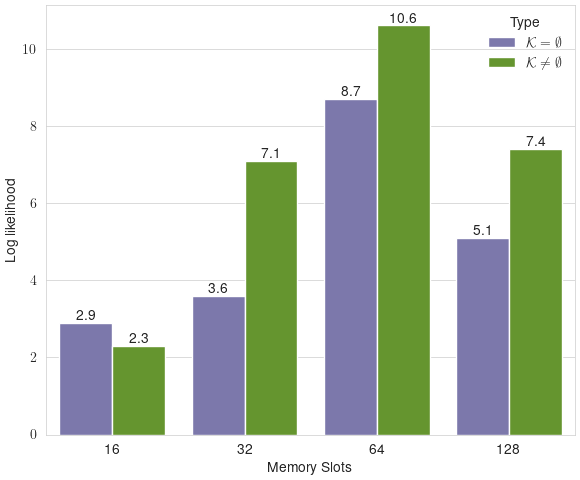

In [18]:
raw = [2.9, 3.6, 8.7, 5.1]
informed = [2.3, 7.1, 10.6, 7.4]

# Create DataFrame for seaborn
data = pd.DataFrame({
    'Memory Slots': ['16']*2 + ['32']*2 + ['64']*2 + ['128']*2,
    'Type': ['Raw', 'Informed']*4,
    'Value': [raw[0], informed[0], raw[1], informed[1], raw[2], informed[2], raw[3], informed[3]]
})

data["Type"] = data["Type"].map(
    {
        "Raw": r"$\mathcal{K} = \emptyset$",
        "Informed": r"$\mathcal{K} \neq \emptyset$",
    }
)

# Set figure size
plt.figure(figsize=(6, 5))

# Create plot using seaborn
ax = sns.barplot(
    data=data,
    x='Memory Slots',
    y='Value',
    hue='Type',
    palette=['C2', 'C4']
)

plt.ylabel('Log likelihood')

for i, bar in enumerate(ax.patches):
    if bar.get_height() != 0:  # Only add text if height is not 0
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            f'{bar.get_height():.1f}',
            ha='center',
            va='bottom'
        )

plt.tight_layout()
plt.savefig('./artifacts/memory_slots_log_likelihood.pdf', bbox_inches='tight')
plt.show()
